In [465]:
# Fix the SVG content by declaring the 'inkscape' namespace properly
# Read the SVG content from file
with open('data/floorplan.svg', 'r') as file:
    svg_content = file.read()

In [466]:
# Parse SVG and extract elements
from xml.etree import ElementTree as ET

ns = {'svg': 'http://www.w3.org/2000/svg', 'inkscape': 'http://www.inkscape.org/namespaces/inkscape'}

tree = ET.ElementTree(ET.fromstring(svg_content))
root = tree.getroot()

In [467]:
import numpy as np
from shapely.affinity import rotate


def parse_rect_with_rotation(elem):
    x = float(elem.attrib.get("x", 0))
    y = float(elem.attrib.get("y", 0))
    w = float(elem.attrib.get("width", 0))
    h = float(elem.attrib.get("height", 0))

    # Build basic rectangle
    poly = Polygon([
        (x, y), (x + w, y),
        (x + w, y + h), (x, y + h)
    ])

    # Parse transform if exists
    transform = elem.attrib.get("transform", "")
    if "rotate" in transform:
        match = re.search(r'rotate\(([-+]?[0-9]*\.?[0-9]+)\)', transform)
        if match:
            angle = float(match.group(1))
            rotated_poly = poly  # rotate(poly, angle, use_radians=False)
            return rotated_poly

    return poly

In [468]:
def parse_path(d_attr):
    commands = re.findall(r'([MLHVZmlhvz])([^MLHVZmlhvz]*)', d_attr)
    vertices = []
    current_pos = (0.0, 0.0)
    start_point = None

    for cmd, args in commands:
        args = [float(n) for n in re.findall(r'[-+]?[0-9]*\.?[0-9]+', args)]
        is_relative = cmd.islower()
        cmd = cmd.upper()

        if cmd == 'M':
            for i in range(0, len(args), 2):
                x, y = args[i], args[i + 1]
                if is_relative:
                    x += current_pos[0]
                    y += current_pos[1]
                current_pos = (x, y)
                vertices.append(current_pos)
                if start_point is None:
                    start_point = current_pos

        elif cmd == 'L':
            for i in range(0, len(args), 2):
                x, y = args[i], args[i + 1]
                if is_relative:
                    x += current_pos[0]
                    y += current_pos[1]
                current_pos = (x, y)
                vertices.append(current_pos)

        elif cmd == 'H':
            for x in args:
                if is_relative:
                    x += current_pos[0]
                current_pos = (x, current_pos[1])
                vertices.append(current_pos)

        elif cmd == 'V':
            for y in args:
                if is_relative:
                    y += current_pos[1]
                current_pos = (current_pos[0], y)
                vertices.append(current_pos)

        elif cmd == 'Z':
            if start_point and current_pos != start_point:
                vertices.append(start_point)
            current_pos = start_point

    if len(vertices) >= 3:
        poly = Polygon(vertices)
        return poly if poly.is_valid else None
        return None


In [469]:
from shapely.geometry import Point, Polygon


# Helper to extract desk points
def extract_floor_plan(svg_root):
    for g in svg_root.findall(".//svg:g[@inkscape:label='floor_layer']", ns):
        for path in g.findall(".//svg:path", ns):
            d_attr = path.attrib.get("d", "")
            polygon = parse_path(d_attr)
            if polygon:
                return polygon
    return None


In [470]:
from shapely.geometry import Point, Polygon


# Helper to extract desk points

In [471]:
# Helper to extract desk points
def extract_desks(svg_root):
    desks = []
    for g in svg_root.findall(".//svg:g[@inkscape:label='desk_layer']", ns):
        for c in g.findall(".//svg:circle", ns):
            cx = float(c.attrib.get("cx"))
            cy = float(c.attrib.get("cy"))
            r = float(c.attrib.get("r"))
            desk_id = c.attrib.get("id", None)  # Get the id attribute
            points = [
                (cx - r, cy - r),  # top left
                (cx + r, cy - r),  # top right
                (cx + r, cy + r),  # bottom right
                (cx - r, cy + r),  # bottom left
                (cx - r, cy - r)  # close the polygon by repeating first point
            ]
            desks.append((Polygon(points), desk_id))  # Return tuple of (polygon, id)
        for r in g.findall(".//svg:rect", ns):
            desk_poly = parse_rect_with_rotation(r)
            desk_id = r.attrib.get("id", None)  # Get the id attribute
            desks.append((desk_poly, desk_id))  # Return tuple of (polygon, id)
        for path in g.findall(".//svg:path", ns):
            d_attr = path.attrib.get("d", "")
            polygon = parse_path(d_attr)
            desk_id = path.attrib.get("id", None)  # Get the id attribute
            if polygon:
                desks.append((polygon, desk_id))  # Return tuple of (polygon, id)
    return desks


In [472]:
from shapely.geometry import Polygon
import re


def extract_obstacles_with_full_path_support(svg_root):
    obstacles = []
    for g in svg_root.findall(".//svg:g[@inkscape:label='obstacle_layer']", ns):
        for path in g.findall(".//svg:path", ns):
            d_attr = path.attrib.get("d", "")
            polygon = parse_path(d_attr)
            if polygon:
                obstacles.append(polygon)
    return obstacles

In [473]:
floor = extract_floor_plan(root)
# floor

In [474]:
# Extract desk data
desks = extract_desks(root)
# desks

In [475]:
# Extract obstacle data
obstacles = extract_obstacles_with_full_path_support(root)
# obstacles

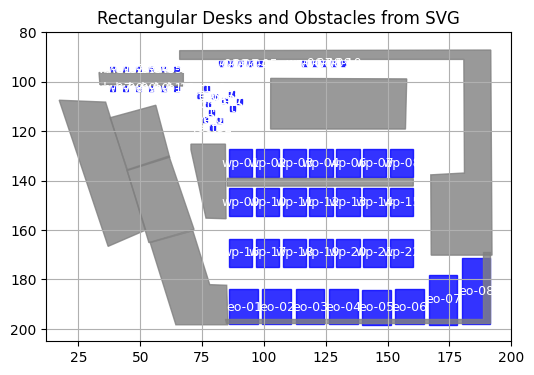

In [476]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

for desk, desk_id in desks:
    x, y = desk.exterior.xy
    ax.fill(x, y, color='blue', alpha=0.8)
    if desk_id:
        ax.text(desk.centroid.x, desk.centroid.y, desk_id, fontsize=9, color='white', ha='center', va='center')

for poly in obstacles:
    x, y = poly.exterior.xy
    ax.fill(x, y, color='gray', alpha=0.8)

ax.set_title("Rectangular Desks and Obstacles from SVG")
ax.set_xlim(12, 200)
ax.set_ylim(80, 205)
ax.set_aspect('equal')
ax.grid(True)
plt.gca().invert_yaxis()
plt.show()

In [477]:
def generate_walkability_graph(floor, desks, obstacles, grid_size=5, padding=1):
    """
    Generate nodes and edges for a walkability graph based on floor plan, desks, and obstacles.

    Args:
        floor (Polygon): The floor boundary polygon
        desks (list): List of (desk_polygon, desk_id) tuples
        obstacles (list): List of obstacle polygons
        grid_size (int): Size of the grid cells for node placement

    Returns:
        tuple: (nodes, edges) where nodes is a list of Points and edges is a list of (start, end) Point tuples
    """
    from shapely.geometry import Point, LineString
    import numpy as np

    # Convert desks to just polygons for processing
    desk_polygons = [desk[0] for desk in desks]

    # Get bounds of the floor
    minx, miny, maxx, maxy = floor.bounds

    # Generate grid points
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)

    nodes = []
    # Generate nodes
    for x in x_coords:
        for y in y_coords:
            point = Point(x, y)

            # Check if point is inside floor and not in any obstacle or desk
            if (floor.contains(point) and
                    not any(obs.contains(point) for obs in obstacles) and
                    not any(desk.contains(point) for desk in desk_polygons)):

                # Add some padding around obstacles and desks
                is_valid = True

                for obs in obstacles:
                    if point.distance(obs) < padding:
                        is_valid = False
                        break

                for desk in desk_polygons:
                    if point.distance(desk) < padding:
                        is_valid = False
                        break

                if is_valid:
                    nodes.append(point)

    # Add desk centroids as nodes
    desk_nodes = []
    for desk, desk_id in desks:
        centroid = Point(desk.centroid)
        desk_nodes.append(centroid)
        nodes.append(centroid)

    # Generate edges
    edges = []

    # First, connect regular walkable nodes
    for i, node1 in enumerate(nodes):
        for node2 in nodes[i + 1:]:
            if node1 in desk_nodes and node2 in desk_nodes:
                continue  # Skip direct desk-to-desk connections

            # Adjust distance threshold based on whether connecting to a desk
            max_distance = grid_size * 4.0 if (node1 in desk_nodes or node2 in desk_nodes) else grid_size * 1.5

            if node1.distance(node2) < max_distance:
                line = LineString([node1, node2])

                # Check if edge intersects any obstacle
                valid_edge = True
                for obs in obstacles:
                    if line.intersects(obs):
                        valid_edge = False
                        break

                # For desk connections, we only check obstacles
                if node1 in desk_nodes or node2 in desk_nodes:
                    if valid_edge:
                        edges.append((node1, node2))
                    continue

                # For non-desk connections, check both obstacles and desks
                for desk in desk_polygons:
                    if line.intersects(desk):
                        valid_edge = False
                        break

                if valid_edge:
                    edges.append((node1, node2))

    # Ensure all desk nodes are connected to at least one walkable node
    for desk_node in desk_nodes:
        if not any(desk_node in edge for edge in edges):
            # Find the closest walkable node
            non_desk_nodes = [n for n in nodes if n not in desk_nodes]
            closest_node = min(non_desk_nodes, key=lambda n: desk_node.distance(n))
            line = LineString([desk_node, closest_node])

            # Check if the connection is valid (doesn't intersect obstacles)
            valid_connection = True
            for obs in obstacles:
                if line.intersects(obs):
                    valid_connection = False
                    break

            if valid_connection:
                edges.append((desk_node, closest_node))

    return nodes, edges

In [478]:
import matplotlib.pyplot as plt


def plot_walkability_graph(floor, obstacles, desks, nodes, edges):
    # Create a new figure
    plt.figure(figsize=(12, 8))

    # Plot the floor boundary
    x, y = floor.exterior.xy
    plt.plot(x, y, 'k-', label='Floor')

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.plot(x, y, 'r-', label='Obstacle')

    # Plot desks
    for desk in desks:
        x, y = desk.exterior.xy
        plt.plot(x, y, 'b-', label='Desk')

    # Plot nodes
    node_x = [node.x for node in nodes]
    node_y = [node.y for node in nodes]
    plt.scatter(node_x, node_y, c='g', s=5, label='Nodes')

    # Plot edges
    for start, end in edges:
        plt.plot([start.x, end.x], [start.y, end.y], 'g-', alpha=0.5)

    # Remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Set equal aspect ratio
    plt.axis('equal')
    plt.grid(True)

    # Flip the y-axis
    plt.gca().invert_yaxis()

    plt.show()


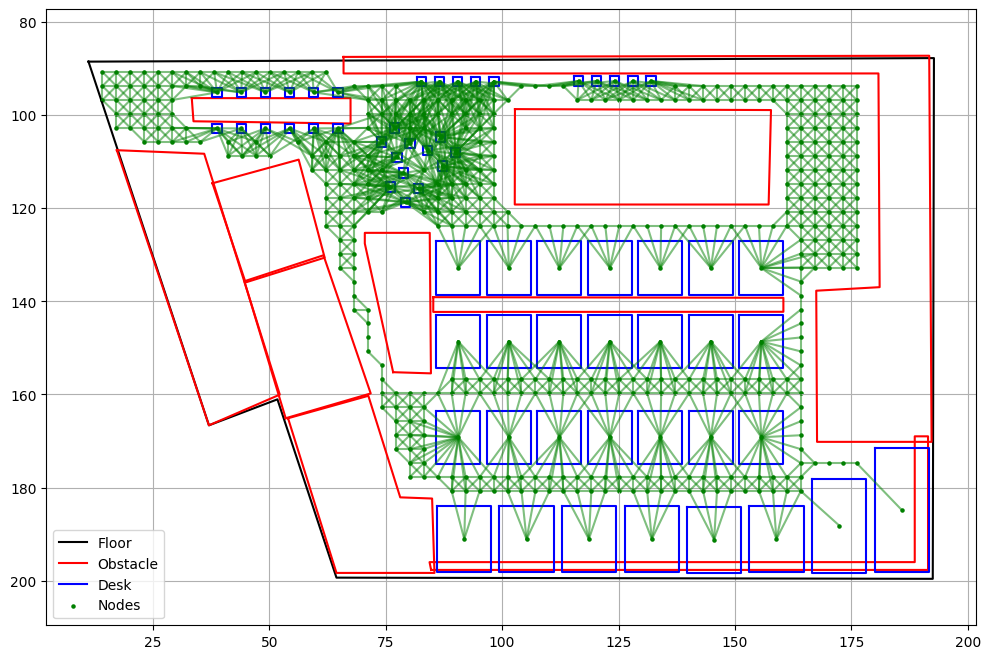

In [479]:
# Generate the walkability graph
nodes, edges = generate_walkability_graph(floor, desks, obstacles, grid_size=3, padding=2)

# Then you can use your existing plotting function
plot_walkability_graph(floor, obstacles, [desk[0] for desk in desks], nodes, edges)